[*********************100%%**********************]  1 of 1 completed
/var/folders/xh/0c12lvfd59g57dbp9dpbncb00000gn/T/ipykernel_53894/3264677401.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


Date
2023-07-11    32.841835
2023-07-12    33.512474
2023-07-13    33.403988
2023-07-14    32.693893
2023-07-17    33.897110
2023-07-18    34.025322
2023-07-19    33.985870
2023-07-20    32.910870
2023-07-21    33.551926
2023-07-24    33.167294
2023-07-25    33.630821
2023-07-26    33.887245
2023-07-27    34.074631
2023-07-28    36.323265
2023-07-31    35.277843
2023-08-01    35.307434
2023-08-02    33.916832
2023-08-03    34.390232
2023-08-04    34.781193
2023-08-07    34.870277
2023-08-08    34.662422
2023-08-09    33.929977
2023-08-10    34.325893
2023-08-11    34.533749
2023-08-14    35.315681
2023-08-15    34.414970
2023-08-16    33.187634
2023-08-17    32.247334
2023-08-18    32.415600
2023-08-21    32.801617
2023-08-22    32.554173
2023-08-23    33.633041
2023-08-24    32.257233
2023-08-25    32.910496
2023-08-28    33.276714
2023-08-29    33.959671
2023-08-30    34.177422
2023-08-31    34.781193
2023-09-01    36.236187
2023-09-05    36.335167
2023-09-06    36.602406
2023-09-07 

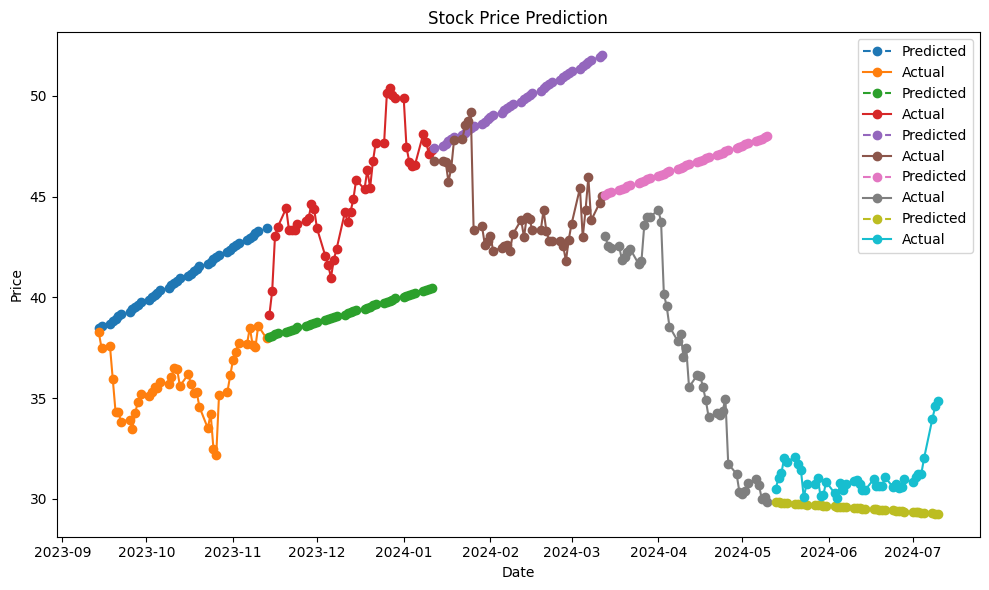

In [18]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pandas_market_calendars as mcal
import yfinance as yf
from pandas.tseries.offsets import CustomBusinessDay
import matplotlib.pyplot as plt

# Load your data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data_total = yf.download("INTC", period="1y")
data = data_total["Adj Close"]
print(data)
# Get the NYSE trading calendar
nyse = mcal.get_calendar('NYSE')

# Define a custom business day frequency using the NYSE calendar
custom_BDay = CustomBusinessDay(calendar=nyse)

# Set the frequency to custom business days
data = data.asfreq(custom_BDay)
data = data.fillna(method='ffill')

print(data.isnull().sum())

# Define the number of splits for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Store results
rmse_scores = []
predictions_list = []

# Plotting setup
plt.figure(figsize=(10, 6))
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')

for train_index, test_index in tscv.split(data):
    train, test = data.iloc[train_index], data.iloc[test_index]
    
    # Fit the model
    model = ExponentialSmoothing(train, trend='add', seasonal=None)
    fit = model.fit()
    
    # Make predictions
    predictions = fit.forecast(len(test))
    predictions_list.extend(predictions)
    
    # Calculate RMSE
    rmse = mean_squared_error(test, predictions)
    rmse_scores.append(rmse)

    plt.plot(test.index, predictions, label='Predicted', linestyle='--', marker='o')
    plt.plot(test.index, test, label='Actual', marker='o')
    plt.legend()

# Average RMSE across all folds
average_rmse = sum(rmse_scores) / len(rmse_scores)
print(f'Average RMSE: {average_rmse}')

plt.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed
/var/folders/xh/0c12lvfd59g57dbp9dpbncb00000gn/T/ipykernel_53894/1026531923.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.asfreq('B').fillna(method='ffill')


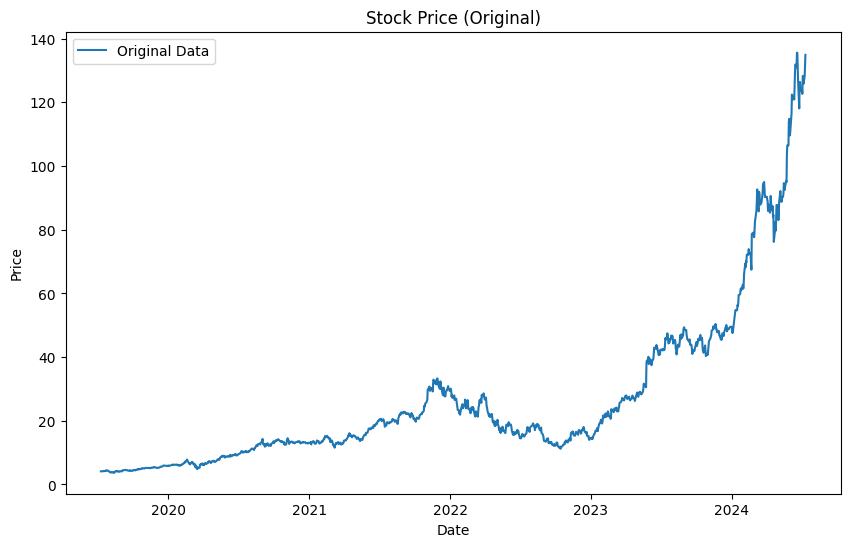

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


KeyboardInterrupt: 

In [37]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

data_total = yf.download("NVDA", period="1y")
data = data_total["Adj Close"]

data = data.asfreq('B').fillna(method='ffill')
plt.figure(figsize=(10, 6))
plt.plot(data.index, data, label='Original Data')
plt.title('Stock Price (Original)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Split data into training and testing sets
train_size = int(len(data) * 0.8)  # 80% train, 20% test
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train, order=(50,0,0))  # Example ARIMA(5,1,25) model
fit_model = model.fit()
print(fit_model.summary())

# In-sample prediction and evaluation
train_predictions = fit_model.predict()
train_rmse = mean_squared_error(train.iloc[0:], train_predictions)
print(f'Train RMSE: {train_rmse}')

# Out-of-sample prediction and evaluation
test_predictions = fit_model.forecast(steps=len(test))
test_rmse = mean_squared_error(test, test_predictions)
print(f'Test RMSE: {test_rmse}')

plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, test_predictions, label='Predicted Test Data', linestyle='--')
plt.title('Stock Price Prediction using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

forecast_horizon = 200  # Number of periods into the future
forecast = fit_model.forecast(steps=forecast_horizon)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label='Original Data')
future_index = pd.date_range(start=data.index[-1], periods=forecast_horizon+1, freq=data.index.freq)[1:]
plt.plot(future_index, forecast, label='Forecasted Values', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Forecast')
plt.legend()
plt.show()
